# SIIM-ACR Pneumothorax Segmentation

## Classification model ( Part 1 )

In this challenge, the distribution of patient labelled with positive pneumothorax is heavily imbalanced. Since the actual occurrence of pneumothorax in a patient is small, we are not surprised that the majority of the instances are negatives. This will introduce some problem in learning to detect the patient with pneumothorax.

To better handle this task, we decided to split out detection algorithm into 2 stages.

**:: Stage 1 ::**

We allow the images to pass through a classification model to determine if they have pneumothorax or not. This is to aid our segmenting models to better identify the positive patients where it acts as a secondary detector to provide assistance in confirming the classes.

In our strategy to train the classifier, we built a total of 3 classification models to predict the classes of pneumothorax.

**Our classification models built in this challenge**

> 1. Efficient model (with bounding boxes)
> 2. Xception model (with bounding boxes)
> 3. Efficient model (without bounding boxes)

In addition, we did a small trick to our image augmentation as we attempt to crop the data input to the region of chest level by detecting the chest bounding box of each images. To get the bounding boxes, we exploit the discussion shared by Dr. Konya where he provided us with 1000 hand drawn bounding boxes of the chest. Then, we train a faster RCNN to quickly learn the bounding boxes for the rest of the patients.

We observed that the regional/focused images increase the resolution of the inputs and they remove redundant details of the images that allow the models to learn better.

At last, we will ensemble the 3 models to get our final prediction.

In [2]:
## Loading and importing packages
import os as os
from glob import glob
import tensorflow as tf
import keras
import pandas as pd
import numpy as np

from class_generator import DataGenerator
from metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

# Configure GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3' # uncheck to select gpu devices
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess=tf.Session(config = config)

# Set seed
np.random.seed(609)
tf.set_random_seed(610)

## Load training data and perform train/test split

In [3]:
from sklearn.model_selection import train_test_split
## Import training dataset
train_data = pd.read_csv('train_classification.csv')
## Import bounding boxes
bounding_box = pd.read_csv('bounding_box_siim.csv')

## Splitting data into train/valid set (stratified)
trainset, validset = train_test_split(train_data,
                                      test_size=0.20,
                                      stratify = train_data.Label,
                                      random_state=611)


print('*.*.*.*.*.*.* Data class statistics *.*.*.*.*.*.* \n')
print('number of patients in trainset :: ', len(trainset))
print('number of positive patients in trainset :: ', sum(trainset.Label))
print('train positive ratio :: ', sum(trainset.Label)/len(trainset), '\n')

print('number of patients in validset :: ', len(validset))
print('number of positive patients in validset :: ', sum(validset.Label))
print('validation positive ratio :: ', sum(validset.Label)/len(validset))

*.*.*.*.*.*.* Data class statistics *.*.*.*.*.*.* 

number of patients in trainset ::  9667
number of positive patients in trainset ::  2135
train positive ratio ::  0.22085445329471398 

number of patients in validset ::  2417
number of positive patients in validset ::  534
validation positive ratio ::  0.22093504344228382


## Loading data generator and observing the effect of the augmentations

> ### Data generator with bounding box cropping

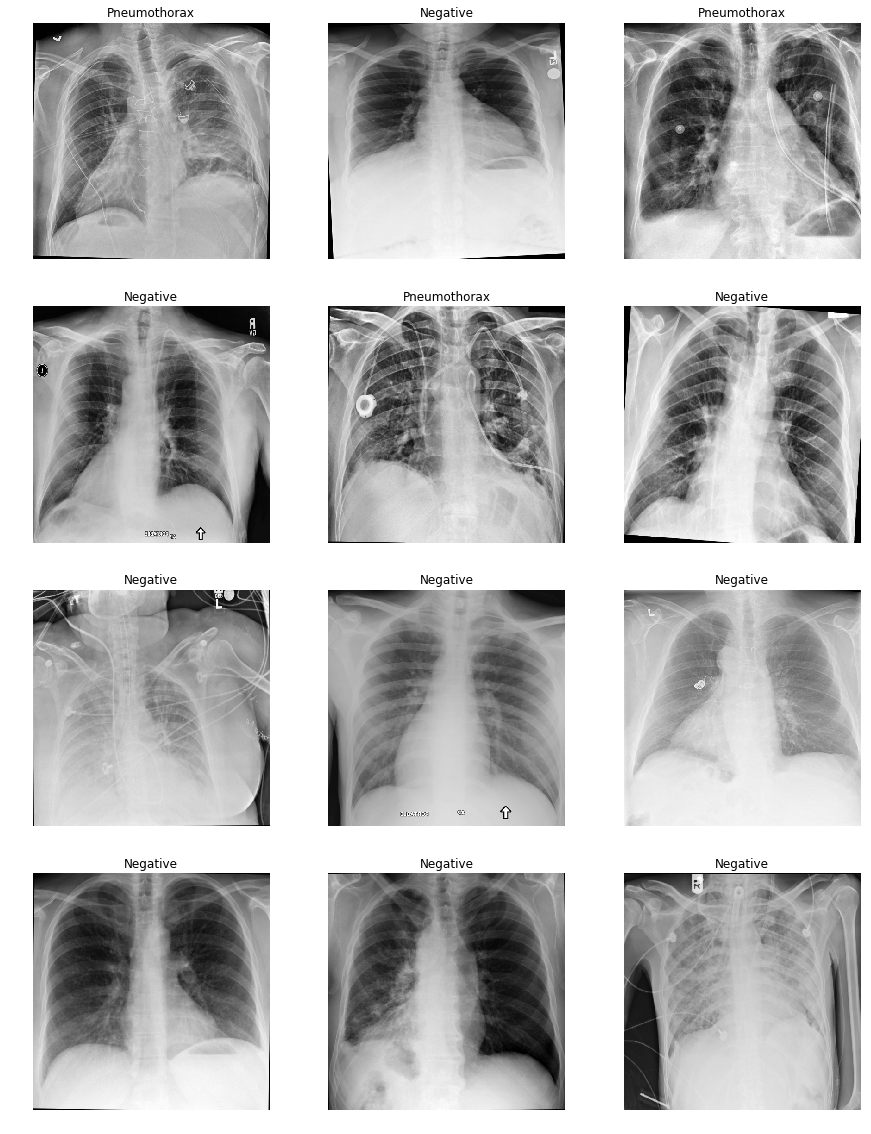

In [4]:
# sanity check (print generator images)
ModelGenerator = DataGenerator(trainset, 
                               image_size=512,
                               batch_size=12,
                               phase = 'train',
                               bounding_box=bounding_box,
                               shuffle=True)

images, labs = ModelGenerator.__getitem__(0)
labels = ['Pneumothorax' if i else 'Negative' for i in labs]

max_images = 12
grid_width = 3
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5., grid_height*5.))

for i, (im,label) in enumerate(zip(images, labels)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,1], cmap="gray")
    ax.set_title(label)
    ax.axis('off')

> ### Data generator without bounding box cropping

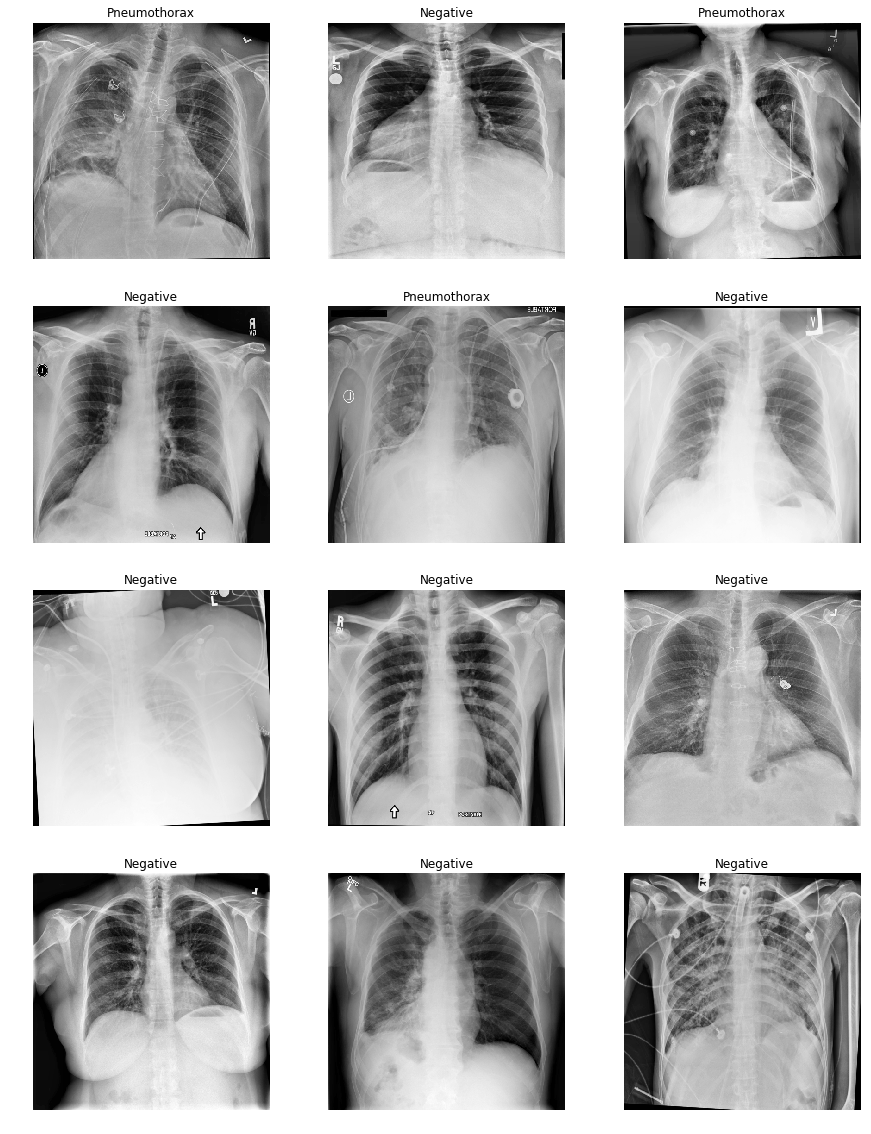

In [5]:
# sanity check (print generator images)
ModelGenerator = DataGenerator(trainset, 
                               image_size=512,
                               batch_size=12,
                               phase = 'train',
                               bounding_box=None,
                               shuffle=True)

images, labs = ModelGenerator.__getitem__(0)
labels = ['Pneumothorax' if i else 'Negative' for i in labs]

max_images = 12
grid_width = 3
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5., grid_height*5.))

for i, (im,label) in enumerate(zip(images, labels)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,1], cmap="gray")
    ax.set_title(label)
    ax.axis('off')

## Build models

In [5]:
# Define model architectures
from class_models import *
keras.backend.clear_session()

# ## Model1 :: Backboned on xception with bounding crop
# model1 = xception_model(input_shape=(512, 512, 3), 
#                         num_classes= 1,
#                         weight= 'imagenet')

# # Model2 :: Backboned on efficientNet with bounding crop
# model2 = EfficientNet_model(input_shape=(512, 512, 3), 
#                             num_classes= 1,
#                             weight= 'imagenet')

# Model3 :: Backboned on efficientNet
model3 = EfficientNet_model(input_shape=(512, 512, 3), 
                            num_classes= 1,
                            weight= 'imagenet')

# Uncheck to enable multi-gpu training
model3 = ModelMGPU(model3, 4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Define training keras callbacks

In [6]:
from keras.callbacks import (ReduceLROnPlateau,
                             ModelCheckpoint,
                             LearningRateScheduler,
                             CSVLogger, 
                             EarlyStopping)

# Define callbacks
def get_callbacks(path):

    # Save checkpoint
    filepath = os.path.join(path,'improved_weights_{epoch:02d}_{val_binary_accuracy:.2f}.hdf5')

    checkpointer = ModelCheckpoint(filepath = filepath,
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   monitor = 'val_binary_accuracy', 
                                   mode = 'max')

    # Early stopping
    stop_train = EarlyStopping(monitor = 'val_loss',
                               patience=10,
                               verbose=1,
                               mode = 'min')

    # Learning rate scheduling
    schedule_lr = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    mode = 'min',
                                    patience=1,
                                    min_lr=1e-9,
                                    cooldown=1)

    # CSV logger
    logger = CSVLogger(os.path.join(path,'training_log.csv'))

    # design callbacks
    callback_list = [schedule_lr, stop_train, checkpointer, logger]

    return callback_list

## Setting up environment and train individual selected model
We create folders 
> `classification_model1`
> `classification_model2` 
> `classification_model3` 

to store all our training log records and saved weights for the three different models.

In [ ]:
from keras.optimizers import Adam
from keras.metrics import binary_accuracy
## Set epochs
epochs = 30

## Set batch size
batch_size = 28

## Learning rate
# using efficientnet lr :: 3e-4
# using xception lr :: 3e-5
learning_rate = 3e-4  

# Model Metrics
metrics = [binary_accuracy]

# Set loss :: weighted bce with beta = 2
loss = weighted_bce(2)

# Set callbacks
callbacks = get_callbacks('classification_model3')

# Compile model
model3.compile(loss=loss, optimizer=Adam(lr=learning_rate), metrics=metrics)

## Setup data generator
train_generator = DataGenerator(trainset, 
                                image_size=512,
                                batch_size=batch_size,
                                phase = 'train',
                                bounding_box=None,
                                shuffle=True)

valid_generator = DataGenerator(validset, 
                                image_size=512,
                                batch_size=batch_size,
                                phase = 'test',
                                bounding_box=None,
                                shuffle=False)

## Fit model
model3.fit_generator(generator=train_generator,
                     steps_per_epoch=len(train_generator), 
                     epochs = epochs, verbose=1, 
                     callbacks = callbacks,
                     validation_data=valid_generator,
                     validation_steps=len(valid_generator),
                     max_queue_size=12,
                     workers=12, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
345/345 [==============================] - 487s 1s/step - loss: 0.6054 - binary_accuracy: 0.7789 - val_loss: 0.4442 - val_binary_accuracy: 0.8555

Epoch 00001: val_binary_accuracy improved from -inf to 0.85548, saving model to classification_model3/improved_weights_01_0.86.hdf5


# Section 2 :: Ensembling models

In this section, we build an ensembling model with learnable parameters trained with backpropagation. This will connect the bottleneck layer (final layer before sigmoid output) of the three models with additional fully connected layers. Then, we will fine-tune the model with multiple epochs.

In [7]:
# import graph models and load weights
from class_models import *
keras.backend.clear_session()

# load model 1 ...
model1 = xception_model(input_shape=(512, 512, 3), 
                        num_classes= 1)
model1.load_weights('saved_weights/classification/xception_with_bb.hdf5')

# load model 2 ...
model2 = EfficientNet_model(input_shape=(512, 512, 3), 
                            num_classes= 1)
model2.load_weights('saved_weights/classification/efficientnet_with_bb.hdf5')

# load model 3 ...
model3 = EfficientNet_model(input_shape=(512, 512, 3), 
                            num_classes= 1)
model3.load_weights('saved_weights/classification/efficientnet_plain.hdf5')


candidates = [model1, model2, model3]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Create stacked model 

In [8]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate

## Make stacked model from multiple member input models
def define_stacked_model(members):
    
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
            
    # create placeholder for multi-input
    ensemble_visible = [model.input for model in members]
    
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    
    # fully connected layers
    hidden = Dense(28, activation='relu')(merge)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)

    return model

## Setup environment and train our stack model

We create a folder called `classification_stacked_model` to store our training log records and saved weights.

In [ ]:
from keras.optimizers import Adam
from keras.metrics import binary_accuracy

# Set num models
num_model = 3

## Set epochs
epochs = 20

## Set batch size
batch_size = 28

## Learning rate
learning_rate = 3e-4  

# Model Metrics
metrics = [binary_accuracy]

# Set loss :: weighted bce with beta = 2
loss = weighted_bce(2)

# Set callbacks
callbacks = get_callbacks('classification_stacked_model')

# Compile model
stacked_model = define_stacked_model(candidates)
stacked_model = ModelMGPU(stacked_model, 4) # uncheck to use multi GPU training
stacked_model.compile(loss=loss, optimizer=Adam(lr=learning_rate), metrics=metrics)

train_stack_gen = DataGenerator(trainset, 
                                image_size=512,
                                batch_size=batch_size,
                                phase = 'train',
                                bounding_box=bounding_box,
                                num_ensemble=num_model,
                                shuffle=True)

valid_stack_gen = DataGenerator(validset, 
                                image_size=512,
                                batch_size=batch_size,
                                phase = 'test',
                                bounding_box=None,
                                num_ensemble=num_model,
                                shuffle=False)

## Fit model
stacked_model.fit_generator(generator=train_stack_gen,
                            steps_per_epoch=len(train_stack_gen), 
                            epochs = epochs, verbose=1, 
                            callbacks = callbacks,
                            validation_data=valid_stack_gen,
                            validation_steps=len(valid_stack_gen),
                            max_queue_size=12,
                            workers=12, use_multiprocessing=True)

Epoch 1/20
345/345 [==============================] - 1181s 3s/step - loss: 0.7049 - binary_accuracy: 0.8256 - val_loss: 0.4687 - val_binary_accuracy: 0.9427

Epoch 00001: val_binary_accuracy improved from -inf to 0.94269, saving model to classification_stacked_model/improved_weights_01_0.94.hdf5
Epoch 2/20
345/345 [==============================] - 1219s 4s/step - loss: 0.4182 - binary_accuracy: 0.9212 - val_loss: 0.2836 - val_binary_accuracy: 0.9323

Epoch 00002: val_binary_accuracy did not improve from 0.94269
Epoch 3/20
  6/345 [..............................] - ETA: 16:12 - loss: 0.3267 - binary_accuracy: 0.9167

## Loading stack model with weights

In [9]:
stacked_model = define_stacked_model(candidates)
stacked_model.load_weights('saved_weights/classification/stack_model.hdf5')

## Checking our model accuracy with validation set

In [10]:
valid_stack_gen = DataGenerator(validset, 
                                image_size=512,
                                batch_size=64,
                                phase = 'test',
                                bounding_box=None,
                                num_ensemble=3,
                                shuffle=False)

from tqdm import tqdm
pred, truth = [], [] 
for i in tqdm(range(len(valid_stack_gen))):
    images, labels = valid_stack_gen.__getitem__(i)
    pred_prob = stacked_model.predict(images)
    pred_prob = np.squeeze(np.stack(pred_prob.astype(np.float64), axis=1)).tolist()
    pred += pred_prob
    tt = labels.astype(np.float64).tolist()
    truth += tt

100%|██████████| 37/37 [03:38<00:00,  5.68s/it]


Confusion matrix, without normalization
[[1752   97]
 [  41  478]]
sensitivity:  0.9210019267822736
specificity:  0.9475392103839914
accuracy of the model:  0.9429044269755895


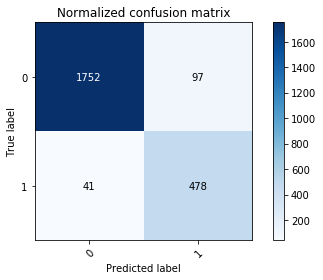

In [11]:
from eval_utils import *
confusion_mat, x = plot_confusion_matrix(truth,
                                         np.int8(np.array(pred) > 0.50),
                                         normalize=False,
                                         title='Normalized confusion matrix')

accuracy = 1 - (x[0,1] + x[1,0]) / len(validset)
print('accuracy of the model: ', accuracy)

Model AUC: ROC AUC=0.983


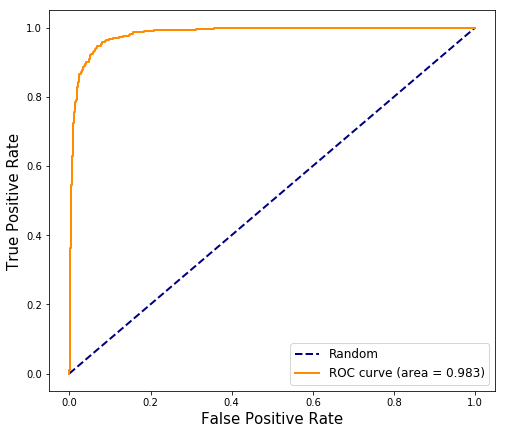

In [13]:
plot_roc_auc(truth, pred)